In [20]:
#from libs.edgelistParser import edgelistParser
#from libs.utils import list2matrix, getInOutDegree, transposeEdgelist, reorderEdgelist
#from libs.page_rank import approximateSimrank, localPageRank
#from libs.plotNetwork import plotNetworkClusters

# use cython compiled modules for faster execution
from scripts.cython.edgelistParser import edgelistParser
from scripts.cython.utils import list2matrix, getInOutDegree, transposeEdgelist, reorderEdgelist
#from scripts.cython.pageRank import approximateSimrank, localPageRank
from scripts.cython.plotNetwork import plotNetworkClusters

from scripts.cpp_libs.pageRankCpp import cppLocalPageRank as localPageRank

import numpy as np
from matplotlib import pyplot as plt
import heapq as hq
import networkx as nx

In [21]:
import pandas as pd

In [22]:
df = pd.read_csv("datasets/Aggregation.txt", sep='\t', names=["x", "y", "cluster"])
df.head()

,x,y,cluster
0,15.55,28.65,2
1,14.90,27.55,2
2,14.45,28.35,2
3,14.15,28.80,2
4,13.75,28.05,2


In [23]:
np.random.seed(0)

In [24]:
clusters = np.array(df.cluster)
centroids = []
for cluster in np.unique(clusters):
    nodes = np.arange(df.shape[0])[clusters==cluster]
    centroids.append(np.random.choice(nodes, 1)[0])
print(centroids)

[753, 47, 541, 455, 757, 682, 179]


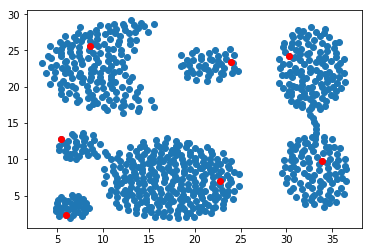

In [25]:
plt.figure()
plt.scatter(df.x, df.y)
plt.scatter(df.x.iloc[centroids], df.y.iloc[centroids], color='r')
plt.show()

In [26]:
positions = np.array(df[["x", "y"]])

In [27]:
def generate_edges(positions, radius=1):
     
    # initialize the edgelist
    N = positions.shape[0]
    idxs = np.arange(N)
    A = [[]]*N
    
    for i in range(N):
        point = positions[i,:]
        dists = np.linalg.norm(point-positions, axis=1)
        neighs = idxs[np.logical_and(dists<=radius, idxs!=i)]
        A[i] = []
        for j, neigh in enumerate(neighs):
            A[i].append((neigh, 1+1./dists[idxs!=i][j]))
            #A[i].append((neigh, 1))
    return A

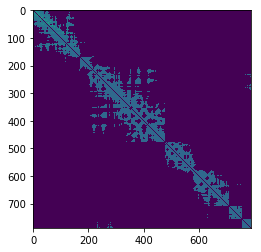

In [28]:
A = generate_edges(positions, 5)
A_mat = list2matrix(A)
plt.figure()
plt.imshow(np.log(A_mat+1))
plt.show()

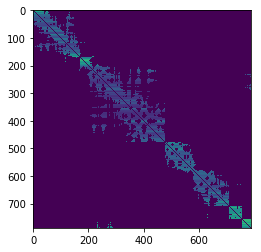

In [29]:
# generate the L matrix
L = localPageRank(A, c=0.85, epsilon=1e-8, max_iters=200, return_only_neighbours=True)

# normalize the edgelist by row
_, outDeg = getInOutDegree(L)
for i, nodelist in enumerate(L):
    for j in range(len(nodelist)):
        if outDeg[i] > 0:
            nodelist[j] = (nodelist[j][0], (1+nodelist[j][1])/(outDeg[i]+len(nodelist)-1))

L_mat = list2matrix(L)
plt.figure()
plt.imshow(np.log(L_mat+1))
plt.show()

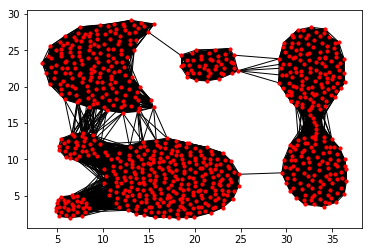

In [30]:
g = nx.Graph(A_mat)
plt.figure()
nx.draw_networkx(g, pos=positions, node_size=10, with_labels=False)
plt.show()

In [31]:
def cluster(L_norm, centroids, A_mat=None, pos=None, colors=None, node_size=10, draw_edges=False):
    # initialize queue with the centroids
    # queue element: (weight, (centroid, path_length))
    queue = [(-1., centroid) for centroid in centroids]
    # initialize the clusters vector
    clusters = -np.ones(len(L), dtype=int)
    clusters[centroids] = centroids
    iters = 0
    
    # iterate until the queue is not empty
    while len(queue)>0:
        
        # pop the first element
        elem = hq.heappop(queue)
        node = elem[1]
        
        #print("Current Weight:", elem[0])
        
        # extract the neighbours
        neighs = L[node]
        
        # for each neighbour
        for neigh in neighs:
            # if it wasn't already assigned
            if clusters[neigh[0]] == -1:
                # assign it to the parent's cluster
                clusters[neigh[0]] = clusters[node]
                # and push it into the global list
                if neigh[1] > 0:
                    hq.heappush(queue, ( elem[0]*neigh[1], neigh[0] ))
                else:
                    hq.heappush(queue, ( elem[0]/2, neigh[0] ))
                
        #if iters%75 == 0:
        #    if A_mat is not None:
        #        pos, colors = plotNetworkClusters(A_mat, list(clusters), node_size, draw_edges=draw_edges, pos=pos, colors=colors)
                
        iters += 1

    if A_mat is not None:
        plotNetworkClusters(A_mat, list(clusters), node_size, draw_edges=draw_edges, pos=pos, colors=colors)
    return clusters

In [32]:
def cluster2(L_norm, centroids, A_mat=None, pos=None, colors=None, node_size=10, draw_edges=False):
    # initialize queue with the centroids
    # queue element: (weight, (node, parent's cluster))
    queue = [(-1., (centroid, centroid)) for centroid in centroids]
    # initialize the clusters vector
    clusters = -np.ones(len(L), dtype=int)
    iters = 0
    
    # iterate until the queue is not empty
    while len(queue)>0:
        
        # pop the first element
        elem = hq.heappop(queue)
        node = elem[1][0]
        clust = elem[1][1]
        
        # if the node was not already assigned
        if clusters[node] == -1:
            
            #assign it to the parent's cluster
            clusters[node] = clust
        
            # extract the neighbours
            neighs = L[node]

            # for each neighbour
            for neigh in neighs:
                # if it wasn't already assigned
                if clusters[neigh[0]] == -1:
                    # and push it into the global list
                    if neigh[1] > 0:
                        hq.heappush(queue, ( elem[0]*neigh[1], (neigh[0], clust) ))
                    else:
                        hq.heappush(queue, ( elem[0]/len(neighs), (neigh[0], clust) ))
                
        #if iters%75 == 0:
        #    if A_mat is not None:
        #        pos, colors = plotNetworkClusters(A_mat, list(clusters), node_size, draw_edges=draw_edges, pos=pos, colors=colors)
                
        iters += 1

    if A_mat is not None:
        plotNetworkClusters(A_mat, list(clusters), node_size, draw_edges=draw_edges, pos=pos, colors=colors)
    return clusters

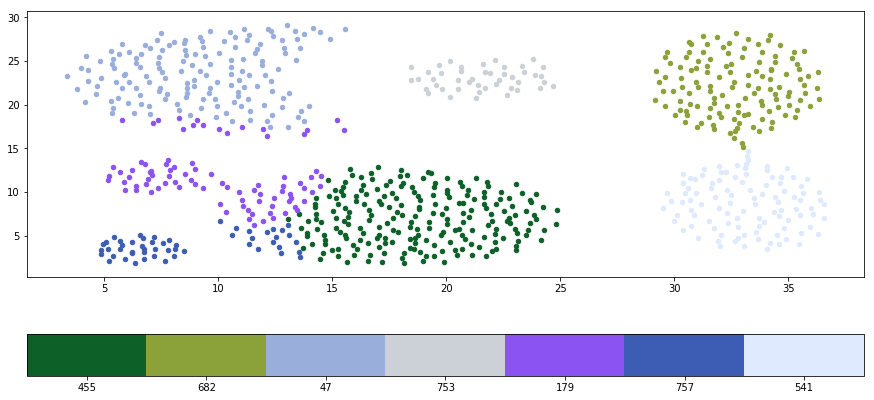

In [33]:
clusters = cluster(L, np.array(centroids), A_mat, pos=positions, node_size=20, draw_edges=False)

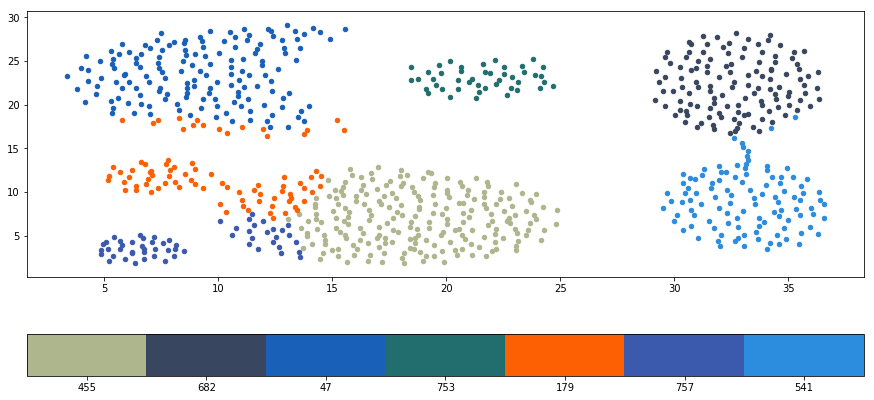

In [34]:
clusters = cluster2(L, np.array(centroids), A_mat, pos=positions, node_size=20, draw_edges=False)